In [2]:
import torch
from procgen import ProcgenGym3Env
from torchinfo import summary
import core

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = None
player = None
ppo = None
env= None
envKW = {}

modelPath = "/storage/home/hcoda1/2/meinhorn6/scratch/RL/models"
def loadAll(fname, loadEnv=True):
    model.load_state_dict(torch.load(modelPath + fname + "/model.pth"))
    player.load_state_dict(torch.load(modelPath + fname + "/player.pth"))
    ppo.load_state_dict(torch.load(modelPath + fname + "/ppo.pth"))
    if loadEnv:
        envKW = torch.load(modelPath + fname + "/envKW.pth")
        env = ProcgenGym3Env(**envKW)
        env.callmethod("set_state", torch.load(modelPath + fname + "/env_states.pth"))
    else:
        player.reset()

def saveAll(fname):
    import os
    os.makedirs(modelPath + fname, exist_ok=True)
    torch.save(model.state_dict(), modelPath + fname + "/model.pth")
    torch.save(player.state_dict(), modelPath + fname + "/player.pth")
    torch.save(ppo.state_dict(), modelPath + fname + "/ppo.pth")
    torch.save(envKW, modelPath + fname + "/envKW.pth")
    torch.save(env.callmethod("get_state"), modelPath + fname + "/env_states.pth")
    torch.save(ppo.all_stats, modelPath + fname + "/stats.pth")
    torch.save(player.trainEpisodeStats, modelPath + fname + "/trainEpisodeStats.pth")


/storage/home/hcoda1/2/meinhorn6/.conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
num_models = 2
num_agents = 64
envKW = core.getKW(num=num_models*num_agents, env_name="coinrun", distribution_mode="easy", paint_vel_info=True, use_backgrounds=False, restrict_themes=True)
env = ProcgenGym3Env(**envKW)
print(env.ob_space)
print(env.ac_space)

Dict(rgb=D256[64,64,3])
D15[]


In [3]:
from CVModels import CNNAgent, ViTValue, ImpalaValue, VectorModelValue
from CVModels import avgSync, sumSync
modelName = "Impala"
if modelName == "Impala":
    model = ImpalaValue().to(device)
elif modelName == "ViT60":
    model = ViTValue(depth=4, num_heads=4, embed_dim=32, mlp_ratio=4, valueHeadLayers=1).to(device)
elif modelName == "ViT15":
    model = ViTValue(depth=3, num_heads=4, embed_dim=16, mlp_ratio=4, valueHeadLayers=1).to(device)
elif modelName == "resnet":
    model = CNNAgent([64, 64, 3], 15, channels=16, layers=[1,1,1,1], scale=[1,1,1,1], vheadLayers=1).to(device)
# model = ViTValue(depth=3, num_heads=4, embed_dim=16, mlp_ratio=4, valueHeadLayers=1).to(device)
model = VectorModelValue(model, n=num_models, syncFunc=avgSync).to(device)
# model = CNNAgent([64, 64, 3], 15, channels=16, layers=[1,1,1,1], scale=[1,1,1,1], vheadLayers=1).to(device)
model.train()
summary(model, input_size=(2, 2, 3, 64, 64))

Layer (type:depth-idx)                        Output Shape              Param #
VectorModelValue                              [2, 2, 15]                --
├─ModuleList: 1-1                             --                        --
│    └─ImpalaValue: 2-1                       [2, 15]                   --
│    │    └─ImpalaModel: 3-1                  [2, 256]                  622,144
│    │    └─Linear: 3-2                       [2, 15]                   3,855
│    │    └─ValueHead: 3-3                    [2, 1]                    257
│    └─ImpalaValue: 2-2                       [2, 15]                   --
│    │    └─ImpalaModel: 3-4                  [2, 256]                  622,144
│    │    └─Linear: 3-5                       [2, 15]                   3,855
│    │    └─ValueHead: 3-6                    [2, 1]                    257
Total params: 1,252,512
Trainable params: 1,252,512
Non-trainable params: 0
Total mult-adds (M): 125.39
Input size (MB): 0.20
Forward/backward pass size

In [4]:
# model.load_state_dict(torch.load(modelPath + "vitNegT8BigFin" + "/model.pth"))
from PPO import VectorPPO
from ProcgenPlayer import VectorPlayer

gamma = 0.99
# gamma = 0.999
rewardScale = 10
terminateReward = 1 - 10.0 / rewardScale

# livingReward = 0
livingReward = -1e-3
# lr = 1e-3
lr = 2.5e-4
# ent_coef = 0
ent_coef = 1e-2
print("terminateReward", terminateReward, "livingReward", livingReward, "discountedSumLiving", livingReward / (1 - gamma)) # if terminate reward > discountedSumLiving the agent will perfer to run into obstacles.

terminateReward 0.0 livingReward -0.001 discountedSumLiving -0.09999999999999991


In [5]:
player = VectorPlayer(env, num_agents=num_agents, num_models=num_models, 
                      epsilon=0.01, epsilon_decay=1, 
                      rewardScale=rewardScale, livingReward=livingReward, terminateReward=terminateReward, 
                      finishedOnly=True, maxStaleSteps=64)
ppo = VectorPPO(model, env, num_agents=num_agents, num_models=num_models, player=player, 
                lr=lr, gamma=gamma, ent_coef=ent_coef, weight_decay=0.0, 
                warmup_steps=10, train_steps=1000, sync_epochs=6,
                batch_size=1, epochs_per_game=3)

c:\ProgramData\Miniconda3\envs\torch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [6]:
# from CVModels import printParams
# # printParams(model.modelList)

# print(list(model.modelList[0].parameters())[0].data, list(model.modelList[1].parameters())[0].data)
# print("before sync")
# model.sync()
# print("after sync")
# # printParams(model.modelList)
# print(list(model.modelList[0].parameters())[0].data, list(model.modelList[1].parameters())[0].data)

# paramList = list(zip(*[list(model.parameters()) for model in model.modelList]))
# print(len(paramList)) # 42 num layers
# print(len(paramList[0])) # 2 num models
# print(paramList[0][0]) # param

In [7]:
# ppo.runGame()
# loss = ppo.train(debug=True)
# print(loss)
# import torchviz
# torchviz.make_dot(torch.sum(loss), params=dict(model.named_parameters()))

In [8]:
# loadAll("vitNegT8BigFin")
print(ppo.params)
print(player.params)
print(envKW)

{'alg_name': 'ppo', 'lr': 0.00025, 'gamma': 0.99, 'lam': 0.95, 'whiten': True, 'cliprange': 0.2, 'cliprange_value': 0.2, 'vf_coef': 0.5, 'epoch_steps': 256, 'epochs_per_game': 3, 'batch_size': 1, 'ent_coef': 0.01, 'weight_decay': 0.0, 'warmup_steps': 10, 'train_steps': 1000, 'sync_epochs': 6, 'sync_steps': -1}
{'alg_name': 'ppo', 'epsilon': 0.01, 'epsilon_decay': 1, 'rewardScale': 10, 'livingReward': -0.001, 'terminateReward': 0.0, 'finishedOnly': True, 'maxStaleSteps': 64}
{'num': 128, 'env_name': 'coinrun', 'distribution_mode': 'easy', 'paint_vel_info': True, 'use_backgrounds': False, 'restrict_themes': True}


In [9]:
for i in range(300 // ppo.params['epochs_per_game']):
    ppo.runGame()
    ppo.train()
    if i % 10 == 0:
        # print("episodeLength", ppo.all_stats[-1]["game/episodeLength"], "episodeReward", ppo.all_stats[-1]["game/episodeReward"],
        #       "epoch", ppo.all_stats[-1]["epoch"], "steps", ppo.all_stats[-1]["steps"], 
        #       "\nloss", ppo.all_stats[-1]["ppo/loss/total"].item(), "policy", ppo.all_stats[-1]["ppo/loss/policy"].item(), 
        #       "value", ppo.all_stats[-1]["ppo/loss/value"].item(),
        #       "entropy", ppo.all_stats[-1]["ppo/policy/entropy"].item())
        print(f"episodeLength {ppo.all_stats[-1]['game/episodeLength']} episodeReward {ppo.all_stats[-1]['game/episodeReward']} " + 
              f"\nepoch {ppo.all_stats[-1]['epoch']} steps {ppo.all_stats[-1]['steps']} " +
              f"\nloss {ppo.all_stats[-1]['ppo/loss/total']} policy {ppo.all_stats[-1]['ppo/loss/policy']} " +
              f"\nvalue {ppo.all_stats[-1]['ppo/loss/value']} entropy {ppo.all_stats[-1]['ppo/policy/entropy']} " +
              f"\ncomms {ppo.all_stats[-1]['sync/comms']} data {ppo.all_stats[-1]['sync/data']} " +
              f"\nstale {ppo.all_stats[-1]['game/staleSteps']}              ")
        # print(ppo.all_stats[-1])
    else:
        print(f"episodeLength {ppo.all_stats[-1]['game/episodeLength']} episodeReward {ppo.all_stats[-1]['game/episodeReward']}               ", end="\r")
        
    if i % (50 // ppo.params['epochs_per_game']) == 0:
        saveAll(f"vector{modelName}{ppo.all_stats[-1]['epoch']}RS{rewardScale}G{gamma}Lv{livingReward!=0}_4-9")
saveAll(f"vector{modelName}{ppo.all_stats[-1]['epoch']}RS{rewardScale}G{gamma}Lv{livingReward!=0}_4-9")

episodeLength [174.57142857142858, 162.57142857142858] episodeReward [-0.1745714368631265, -0.01971429158999984] 
epoch 2 steps 32768 
loss tensor([-0.0300, -0.0289], dtype=torch.float64) policy tensor([-0.0037, -0.0026], dtype=torch.float64) 
value tensor([0.0004, 0.0004], dtype=torch.float64) entropy tensor([2.6759, 2.6728]) 
comms 2 data 9.555908203125 
stale 0              
episodeLength [255.57142857142858, 522.7878787878788] episodeReward [0.19897401970871664, -0.15915153528366124] 
epoch 32 steps 360448 
loss tensor([-0.0300, -0.0303], dtype=torch.float64) policy tensor([-0.0039, -0.0036], dtype=torch.float64) 
value tensor([0.0005, 0.0002], dtype=torch.float64) entropy tensor([2.6597, 2.6926]) 
comms 12 data 57.33544921875 
stale 64              
episodeLength [141.0096153846154, 160.74774774774775] episodeReward [0.3109134606806597, 0.3257387373900578] 
epoch 62 steps 688128 
loss tensor([-0.0331, -0.0323], dtype=torch.float64) policy tensor([-0.0083, -0.0071], dtype=torch.flo

KeyboardInterrupt: 

In [63]:
import matplotlib.pyplot as plt
import os
import numpy as np


filesC = os.listdir(modelPath)
modelName = "impalaVectorV1"
n = 4
k = 1
t = 0
prefix = f"{modelName}-t{t}-k{k}-n{n}"
filesC = [f for f in filesC if prefix in f]
filesC = [f for f in filesC if "4-16" in f]
print(filesC)

modelname = modelPath + "/" + filesC[0]
print(modelname)

all_stats = torch.load(modelname + "/stats.pth")
trainEpisodeStats = torch.load(modelname + "/trainEpisodeStats.pth")

['impalaVectorV1-t0-k1-n4-E4001-RS10-G0.99-LvFalse_4-16']
/storage/home/hcoda1/2/meinhorn6/scratch/RL/models/impalaVectorV1-t0-k1-n4-E4001-RS10-G0.99-LvFalse_4-16


In [64]:
print(len(all_stats))
print(all_stats[0].keys())

4002
dict_keys(['epoch', 'steps', 'objective/vf_coef', 'objective/ent_coef', 'objective/lr', 'game/episodeLength', 'game/nonZeroReward', 'game/episodeReward', 'game/discountedReward', 'game/advantageMean_PreWhiten', 'game/advantageStd_PreWhiten', 'game/staleSteps', 'ppo/reward', 'ppo/loss/policy', 'ppo/loss/value', 'ppo/loss/ent', 'ppo/loss/total', 'ppo/policy/entropy', 'ppo/policy/approxkl', 'ppo/policy/policykl', 'ppo/policy/clipfrac', 'ppo/policy/advantages_mean', 'ppo/policy/ratio_mean', 'ppo/returns/mean', 'ppo/returns/var', 'ppo/val/vpred', 'ppo/val/clipfrac', 'ppo/val/mean', 'ppo/val/var', 'sync/comms', 'sync/data', 'time/runGame', 'time/computeAdvantages', 'time/ppo/forward', 'time/ppo/backward', 'time/ppo/optim', 'time/ppo/stats', 'time/sync', 'time/epoch', 'time/game/observe', 'time/game/act', 'time/game/forward', 'time/game/stats', 'time/game/transition'])


In [65]:
print(len(trainEpisodeStats))
# [currentSteps, currentEpoch, j, i, self.sumRew[j][i], self.sumDiscountRew[j][i], self.zeroRew[j][i], self.timeStep - self.startSteps[j][i]]
# step, epoch, j, i, sumRew, sumDiscountRew, zeroRew, episodeLength
# print(trainEpisodeStats[2000])

0


last 50 0.9582242770958606


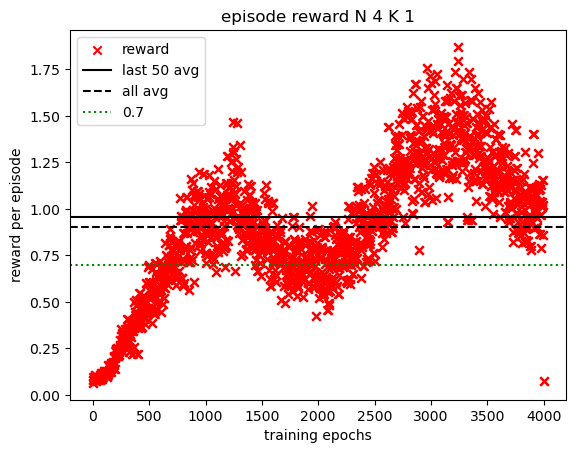

In [66]:
LastE = 50
plt.scatter([s["epoch"] for s in all_stats], [s["game/episodeReward"][0] for s in all_stats], label="reward", color="red", marker="x")
# horizontal line of mean of last 100
print(f"last {LastE}", np.mean([s["game/episodeReward"] for s in all_stats][-LastE:]))
plt.axhline(np.mean([s["game/episodeReward"] for s in all_stats][-LastE:]), color="black", linestyle="-", label=f"last {LastE} avg")
# horizontal line of mean of all
plt.axhline(np.mean([s["game/episodeReward"] for s in all_stats]), color="black", linestyle="--", label="all avg")
# o.7 line
plt.axhline(0.7, color="green", linestyle=":", label="0.7")
plt.xlabel("training epochs")
plt.ylabel("reward per episode")
plt.legend()
plt.title(f"episode reward N {n} K {k}")
plt.show()

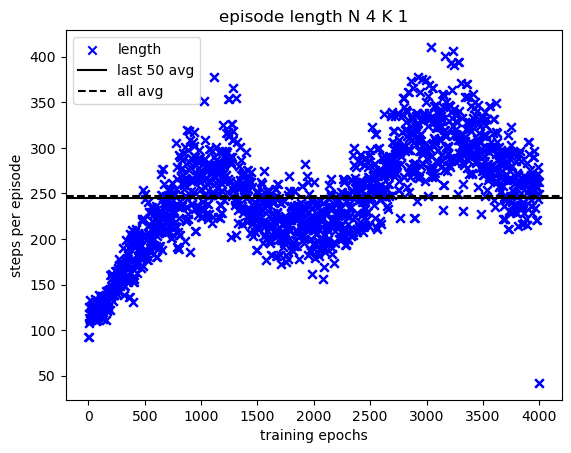

In [67]:
# graph all episode lengths and episode rewards over steps
plt.scatter([s["epoch"] for s in all_stats], [s["game/episodeLength"][0] for s in all_stats], label="length", color="blue", marker="x")
# horizontal line of mean of last 100
plt.axhline(np.mean([s["game/episodeLength"] for s in all_stats][-LastE:]), color="black", linestyle="-", label=f"last {LastE} avg")
# horizontal line of mean of all
plt.axhline(np.mean([s["game/episodeLength"] for s in all_stats]), color="black", linestyle="--", label="all avg")
plt.xlabel("training epochs")
plt.ylabel("steps per episode")
plt.legend()
plt.title(f"episode length N {n} K {k}")
plt.show()

In [70]:
# list folders in /storage/home/hcoda1/2/meinhorn6/scratch/RL/models
files = os.listdir(modelPath)
files = [f for f in files if f.startswith("impalaVector")]
files = [f for f in files if f.endswith("_4-16")]
print(files)
# get the epoch number from the folder name
epoch = [int(f.split("E")[1].split("RS")[0].split("-")[0]) for f in files]
trial = [int(f.split("-t")[1].split("-")[0]) for f in files]
K = [int(f.split("-k")[1].split("-")[0]) for f in files]
N = [int(f.split("-n")[1].split("E")[0].split("-")[0]) for f in files]

# modelDict = {}
# for f, e, t, k, n in zip(files, epoch, trial, K, N):
#     if (k, n, t) not in modelDict:
#         modelDict[(k, n, t)] = (e, f)
#     else:
#         e_old, f_old = modelDict[(k, n, t)]
#         if e > e_old:
#             modelDict[(k, n, t)] = (e, f)
#             # move from models/ to models/backups/
#             os.rename(modelPath + "/" + f_old, modelPath + "/backup/" + f_old)
#             print(f"moved {f_old} to backup")
#         else:
#             os.rename(modelPath + "/" + f, modelPath + "/backup/" + f)
#             print(f"moved {f} to backup")

filesC = os.listdir(modelPath)
modelName = "impalaVectorV1"
prefix = f"{modelName}-t0-k10-n4"
filesC = [f for f in filesC if prefix in f]
filesC = [f for f in filesC if "4-16" in f]
print(filesC)


    



['impalaVectorV1-t1-k1-n2-E4001-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t1-k10-n2-E3302-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t2-k10-n4-E1724-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t1-k10-n4-E1724-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t2-k1-n2-E3998-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t1-k1-n8-E2354-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t1-k100-n4-E1001-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t0-k100-n4-E338-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t2-k10-n2-E2888-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t2-k1-n8-E2498-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t2-k100-n2-E3254-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t0-k1-n1-E4001-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t0-k10-n2-E2003-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t0-k100-n8-E884-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t1-k1-n1-E4001-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t2-k100-n8-E842-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-t1-k100-n2-E3302-RS10-G0.99-LvFalse_4-16', 'impalaVectorV1-

In [71]:
steps = []
comms = []
data = []
avgAllRew = []
avgLastRew = []
avgAllLen = []
avgLastLen = []
threshEpoch = []
threshSteps = []

labels = ["steps", "epoch", "N", "K", "trial", "comms", "data", "avgAllRew", "avgLastRew", "avgAllLen", "avgLastLen"]
labels = labels + ["threshEpoch10", "threshSteps10", "threshEpoch15", "threshSteps15", "threshEpoch20", "threshSteps20", "threshEpoch30", "threshSteps30", "threshEpoch50", "threshSteps50", "threshEpoch70", "threshSteps70"]
print(labels)
csvList = [labels]
thresh = 0.15

for f, e, t, k, n in zip(files, epoch, trial, K, N):
    if not os.path.isfile(modelPath + "/" + f + "/stats.pth"):
        print(f, "no stats.pth")
        continue
    all_stats = torch.load(modelPath + "/" + f + "/stats.pth")
    steps.append(all_stats[-1]["steps"])
    comms.append(all_stats[-1]["sync/comms"])
    data.append(all_stats[-1]["sync/data"])
    # averages over all N models
    avgAllRew.append(np.mean([s["game/episodeReward"] for s in all_stats]))
    avgLastRew.append(np.mean([s["game/episodeReward"] for s in all_stats][-LastE:]))
    avgAllLen.append(np.mean([s["game/episodeLength"] for s in all_stats]))
    avgLastLen.append(np.mean([s["game/episodeLength"] for s in all_stats][-LastE:]))

    rewArr = np.array([s["game/episodeReward"] for s in all_stats])
    # print(np.mean(rewArr[-100:]))
    for i in range(rewArr.shape[1]):
        rewArr[:,i] = np.convolve(rewArr[:,i], np.ones(50), 'same') / 50 # moving average
    # print(np.mean(rewArr[-100:]))
    
    line = [all_stats[-1]["steps"], e, n, k, t, all_stats[-1]["sync/comms"], all_stats[-1]["sync/data"], avgAllRew[-1], avgLastRew[-1], avgAllLen[-1], avgLastLen[-1]]

    for threshTemp in [0.1, 0.15, 0.2, 0.3, 0.5, 0.7]:
        idx = np.nonzero(rewArr > threshTemp)
        if idx[0].shape[0] == 0:
            idx = -100
            print(f"no episode in {f} over {threshTemp} reward avg {avgLastRew[-1]}")
        else:
            idx = idx[0][0]
        
        line = line + [idx, all_stats[idx]["steps"]]

        if threshTemp == thresh:
            threshEpoch.append(idx)
            threshSteps.append(all_stats[idx]["steps"])

    csvList.append(line)

np.savetxt("procgen.csv", csvList, delimiter=",", fmt="%s")

['steps', 'epoch', 'N', 'K', 'trial', 'comms', 'data', 'avgAllRew', 'avgLastRew', 'avgAllLen', 'avgLastLen', 'threshEpoch10', 'threshSteps10', 'threshEpoch15', 'threshSteps15', 'threshEpoch20', 'threshSteps20', 'threshEpoch30', 'threshSteps30', 'threshEpoch50', 'threshSteps50', 'threshEpoch70', 'threshSteps70']
no episode in impalaVectorV1-t1-k10-n2-E3302-RS10-G0.99-LvFalse_4-16 over 0.7 reward avg 0.47718298007727666
no episode in impalaVectorV1-t2-k10-n4-E1724-RS10-G0.99-LvFalse_4-16 over 0.7 reward avg 0.48577850267824213
no episode in impalaVectorV1-t1-k10-n4-E1724-RS10-G0.99-LvFalse_4-16 over 0.5 reward avg 0.3965982297347395
no episode in impalaVectorV1-t1-k10-n4-E1724-RS10-G0.99-LvFalse_4-16 over 0.7 reward avg 0.3965982297347395
no episode in impalaVectorV1-t1-k100-n4-E1001-RS10-G0.99-LvFalse_4-16 over 0.2 reward avg 0.1822939366631423
no episode in impalaVectorV1-t1-k100-n4-E1001-RS10-G0.99-LvFalse_4-16 over 0.3 reward avg 0.1822939366631423
no episode in impalaVectorV1-t1-k10

In [58]:
print(len(steps))

30


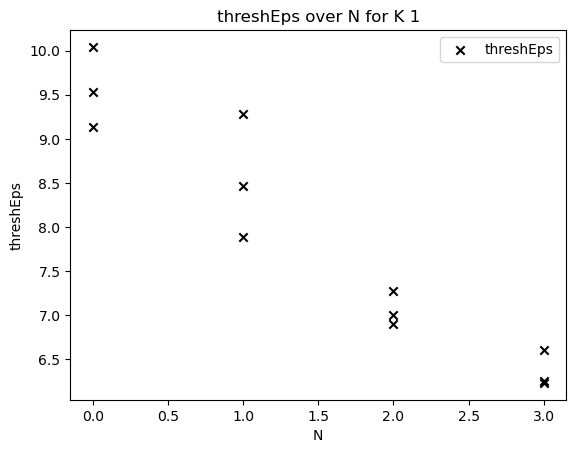

In [78]:
# graph threshEps over N
k = 1
Nk = [np.log2(n) for n, k_ in zip(N, K) if k_ == k or n == 1]
threshEpochk = [np.log2(t) for t, k_, n_ in zip(threshEpoch, K, N) if k_ == k or n_ == 1]

plt.scatter(Nk, threshEpochk, label="threshEps", color="black", marker="x")
plt.xlabel("N")
plt.ylabel("threshEps")
plt.legend()
plt.title(f"threshEps over N for K {k}")
# hline at -100
# plt.axhline(-100, color="black", linestyle="-", label="no episode over thresh")
plt.show()